In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
device = 'cuda:0'
torch.manual_seed(0)
torch.cuda.is_available()

True

In [32]:
opt = {
    "dimension": 3,
    "num_atoms": 300,
    "type_atoms": 3,
    "hidden_size": 100,
}

In [14]:
# Force Field
class ForceField(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_types):
        super(ForceField, self).__init__()
        self.num_types = num_types
        self.layer1 = nn.Linear(input_size + 2 * num_types, hidden_size)
        self.activation = nn.Sigmoid()
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x, types):
        type_one_hot = torch.nn.functional.one_hot(types, num_classes=self.num_types)
        type_one_hot = type_one_hot.view(-1, 2 * self.num_types)
        x = torch.cat([x, type_one_hot], dim=-1)
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x

In [15]:
# Atom Coordinates
class AtomCoordinates(nn.Module):
    def __init__(self, num_atoms, type_atoms, dimension, scale=1):
        super(AtomCoordinates, self).__init__()
        self.coordinates = nn.Parameter(torch.randn(num_atoms, dimension)*scale)
        self.types = nn.Parameter(torch.randint(0, type_atoms, (num_atoms,)), requires_grad=False)

    def forward(self):
        return self.coordinates

In [16]:
# Utility
def distances_matrix(coordinates, atom_types):
    matrix_size = coordinates.shape[0]
    distances = torch.cdist(coordinates, coordinates)
    indices = torch.triu_indices(matrix_size, matrix_size, offset=1)
    distances = distances[indices[0], indices[1]]

    type_pair_matrix = torch.cartesian_prod(atom_types, atom_types).reshape(matrix_size, matrix_size, 2)
    type_pairs = type_pair_matrix[indices[0], indices[1]]
    
    return distances, type_pairs

In [34]:
# Data
def lennard_jones_potential(r, t, a=2, b=2, k=0.5, eps=1e-1):
    t = t - (opt["type_atoms"]-1)/2
    rep = (k * t[:,:1] * t[:,1:]).clone().detach()
    return (1 / ((r+eps)/(a+rep)) ** 12) - (1 / ((r+eps)/(b+rep))**6)

def simulate(force_field, atom_coordinates, atom_types, num_iterations=100, lr=0.01):
    optimizer = optim.Adam([atom_coordinates], lr=lr)
    
    for iteration in range(num_iterations):
        distances, type_pairs = distances_matrix(atom_coordinates, atom_types)
        potential_energy = torch.sum(force_field(distances.view(-1, 1), type_pairs))

        optimizer.zero_grad()
        potential_energy.backward()
        torch.nn.utils.clip_grad_norm_(atom_coordinates, 1)
        optimizer.step()

        if iteration % 100 == -1:  # Adjust the frequency of printing as needed
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()}")

In [18]:
# Train
def train(force_field, atom_coordinates, num_iterations=1000, sim_iterations=1000):
    atom_optimizer = optim.Adam(atom_coordinates.parameters(), lr=0.1)
    force_optimizer = optim.Adam(force_field.parameters(), lr=0.01)
    
    for iteration in range(num_iterations): 
        # Molecular Dynamics Simulation
        if iteration  % sim_iterations == 0:
            stable_coordinates = AtomCoordinates(opt["num_atoms"], opt["type_atoms"], opt["dimension"]).to(device)
            stable_coordinates.types = atom_coordinates.types
            simulate(lennard_jones_potential, stable_coordinates.coordinates, stable_coordinates.types, num_iterations=sim_iterations)
            noise = torch.randn_like(atom_coordinates.coordinates) * 1
            atom_coordinates.coordinates.data.add_(noise)
            
        # Atom Coordinates Update
        atom_distances, atom_type_pairs = distances_matrix(atom_coordinates.coordinates, atom_coordinates.types)
        potential_energy = torch.sum(force_field(atom_distances.view(-1, 1), atom_type_pairs))
        
        atom_optimizer.zero_grad()
        potential_energy.backward()
        atom_optimizer.step()

        # Force Field Update
        temp_coordinates = atom_coordinates.coordinates.detach()
        temp_types = atom_coordinates.types.detach()
        temp_distances, temp_type_pairs = distances_matrix(temp_coordinates, temp_types)
        temp_energy = torch.sum(force_field(temp_distances.view(-1, 1), temp_type_pairs))

        true_coordinates = stable_coordinates.coordinates.detach()
        true_types = stable_coordinates.types.detach()
        true_distances, true_type_pairs = distances_matrix(true_coordinates, true_types)
        true_energy = torch.sum(force_field(true_distances.view(-1, 1), true_type_pairs))

        distances = torch.arange(11, 41, 0.1).view(-1,1).repeat(1, opt["type_atoms"]**2).view(-1,1)
        type_pairs = torch.arange(opt["type_atoms"], dtype=int)
        type_pairs = torch.cartesian_prod(type_pairs, type_pairs).reshape(-1,2).repeat(300,1)
        balance_energy = force_field(distances.to(device), type_pairs.to(device)).reshape(-1, opt["type_atoms"]**2)
        balance_energy = torch.mean(torch.std(balance_energy, dim=1)) + torch.abs(torch.mean(balance_energy))
    
        energy_difference = true_energy - temp_energy
        loss_energy = energy_difference + balance_energy

        force_optimizer.zero_grad()
        loss_energy.backward()
        force_optimizer.step()

        # Optional: Print progress
        if (iteration+1) % 1000 == 0:
            print(f"Iteration {iteration:10},    Energy Difference: {energy_difference.item():10.2f},    Balance Energy: {balance_energy:10.2f}")

In [37]:
atom_coordinates = AtomCoordinates(opt["num_atoms"], opt["type_atoms"], opt["dimension"]).to(device)
force_field = ForceField(1, opt["hidden_size"], 1, opt["type_atoms"]).to(device)
train(force_field, atom_coordinates, 30000, 3000)

Iteration        999,    Energy Difference:    2498.01,    Balance Energy:       2.13
Iteration       1999,    Energy Difference:   -3140.47,    Balance Energy:       8.34
Iteration       2999,    Energy Difference:      66.09,    Balance Energy:       0.03
Iteration       3999,    Energy Difference:      33.66,    Balance Energy:       0.06
Iteration       4999,    Energy Difference:      13.33,    Balance Energy:       0.06
Iteration       5999,    Energy Difference:       3.00,    Balance Energy:       0.03
Iteration       6999,    Energy Difference:       0.45,    Balance Energy:       0.02
Iteration       7999,    Energy Difference:     -27.44,    Balance Energy:       3.70
Iteration       8999,    Energy Difference:      26.85,    Balance Energy:       0.09
Iteration       9999,    Energy Difference:      11.55,    Balance Energy:       0.07
Iteration      10999,    Energy Difference:       9.85,    Balance Energy:       1.15
Iteration      11999,    Energy Difference:      20.83

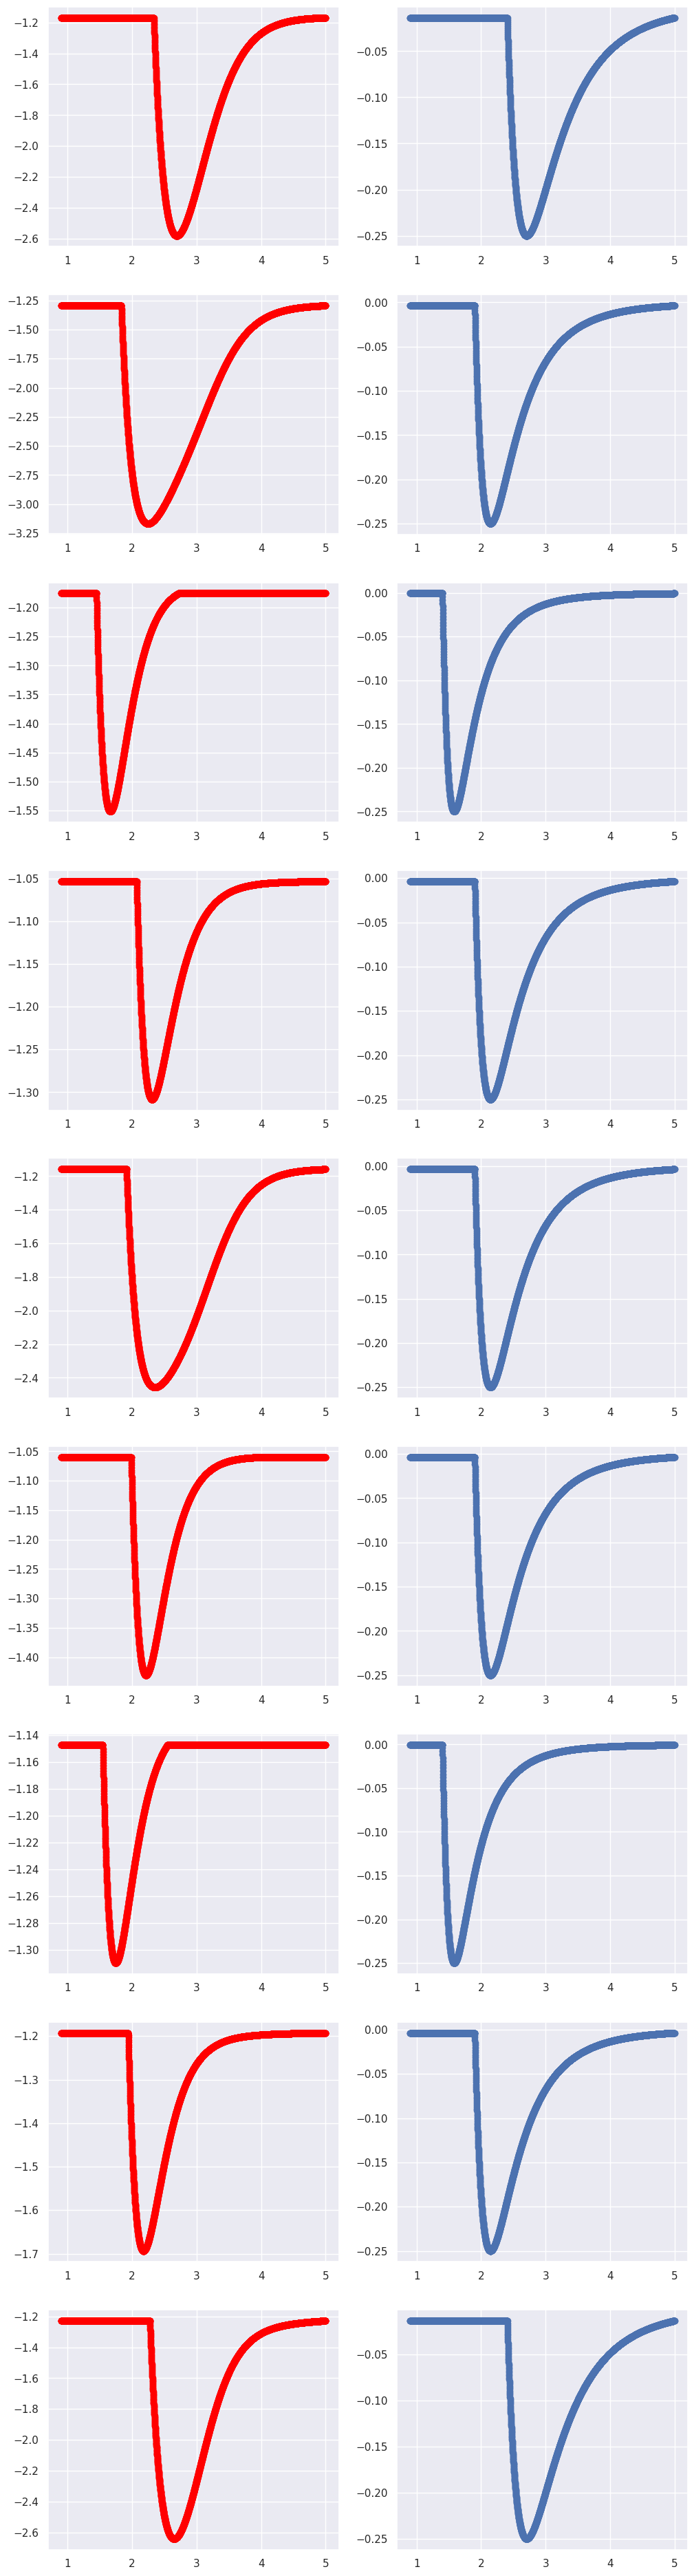

In [80]:
sns.set_theme()
fig, axs = plt.subplots(opt["type_atoms"]**2, 2, figsize=(12, 48))
cnt = 0
for i in range(opt["type_atoms"]):
    for j in range(opt["type_atoms"]):
        x_data = torch.arange(0.9, 5.0, 0.001).unsqueeze(1).to(device)
        x_pair = torch.zeros(x_data.shape[0], 2, dtype=int).to(device)
        x_pair[:, 0] = i
        x_pair[:, 1] = j
        
        y_pred = force_field(x_data, x_pair).detach()
        y_pred = torch.clamp(y_pred, torch.min(y_pred), y_pred[-1])
        y_real = lennard_jones_potential(x_data, x_pair)
        y_real = torch.clamp(y_real, torch.min(y_real), y_real[-1])
        
        axs[cnt, 0].scatter(x_data.cpu().numpy(), y_pred.cpu().numpy(), label=f"Predict: {i} / {j}", color='red')
        axs[cnt, 1].scatter(x_data.cpu().numpy(), y_real.cpu().numpy(), label=f"Real: {i} / {j}")
        cnt += 1

plt.show()

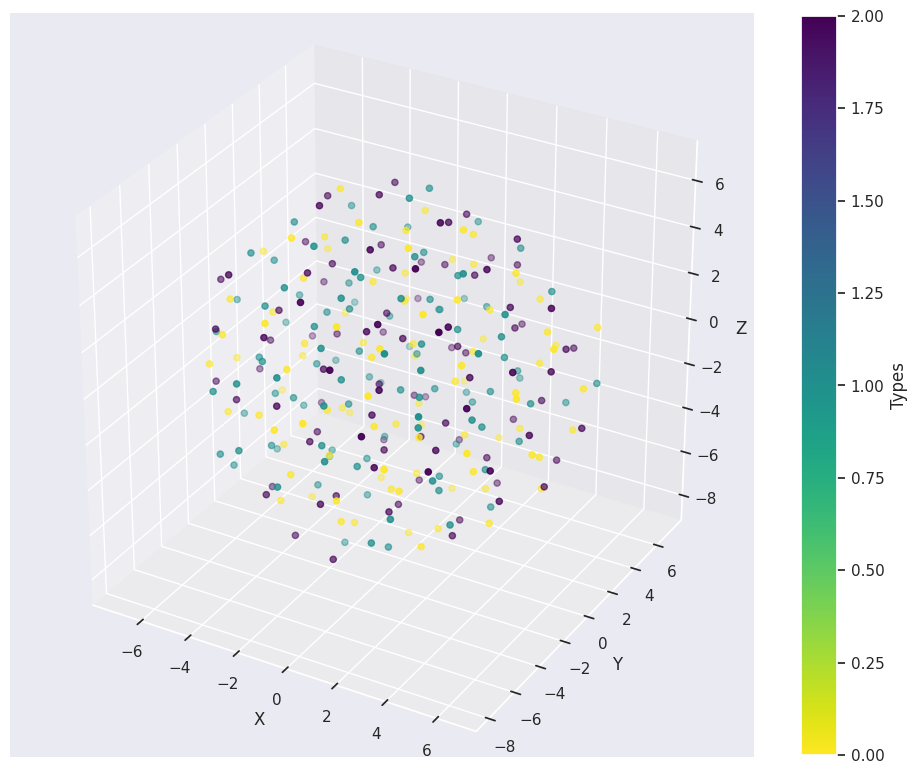

In [99]:
sns.set_theme()
coordinates = atom_coordinates.coordinates.cpu().detach().numpy()
types = atom_coordinates.types.cpu().detach().numpy()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
colormap = plt.get_cmap('viridis_r')
scatter = ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], c=types, cmap=colormap)
colorbar = plt.colorbar(scatter, ax=ax, label='Types', shrink=0.8, orientation='vertical')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_box_aspect([1, 1, 1])
plt.show()

# Save

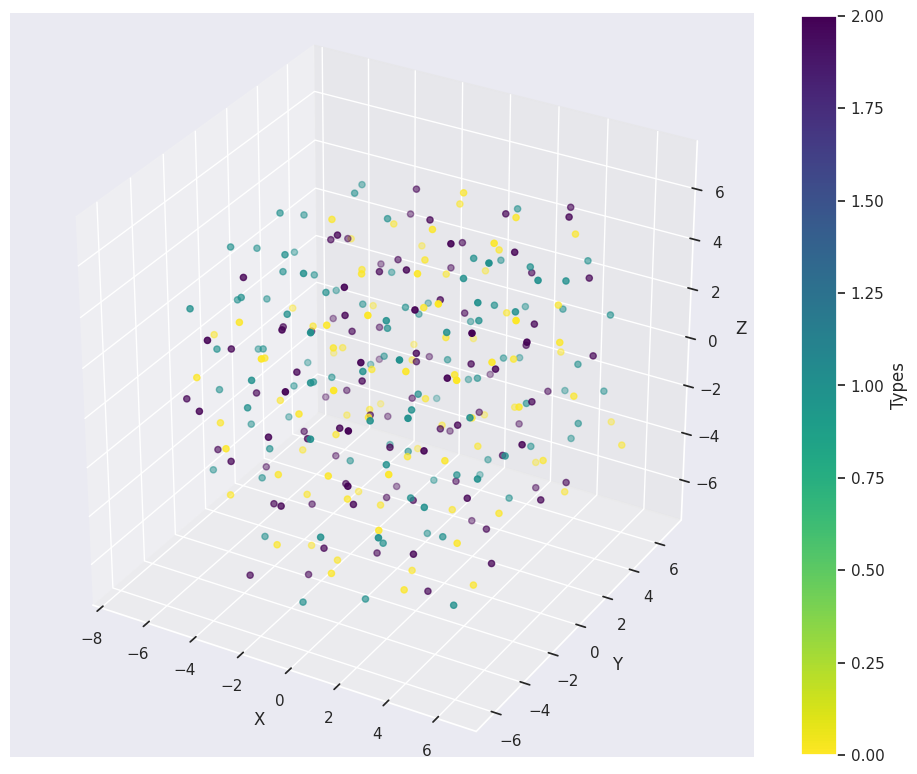

In [101]:
# Simulate Only
stable_coordinates = AtomCoordinates(opt["num_atoms"], opt["type_atoms"], opt["dimension"]).to(device)
simulate(lennard_jones_potential, stable_coordinates.coordinates, stable_coordinates.types, num_iterations=5000)
# 3D
coordinates = stable_coordinates.coordinates.cpu().detach().numpy()
types = stable_coordinates.types.cpu().detach().numpy()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
colormap = plt.get_cmap('viridis_r')
scatter = ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], c=types, cmap=colormap)
colorbar = plt.colorbar(scatter, ax=ax, label='Types', shrink=0.8, orientation='vertical')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_box_aspect([1, 1, 1])
plt.show()

In [ ]:
# Simulate Only
stable_coordinates = AtomCoordinates(opt["num_atoms"], opt["type_atoms"], opt["dimension"]).to(device)
simulate(lennard_jones_potential, stable_coordinates.coordinates, stable_coordinates.types, num_iterations=1000)
# 2D
coordinates = stable_coordinates.coordinates.cpu().detach().numpy()
types = stable_coordinates.types.cpu().detach().numpy()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
colormap = plt.get_cmap('viridis_r')
scatter = ax.scatter(coordinates[:, 0], coordinates[:, 1], c=types, cmap=colormap)
colorbar = plt.colorbar(scatter, ax=ax, label='Types', shrink=0.7, orientation='horizontal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
# Plot 2D
coordinates = atom_coordinates.coordinates.cpu().detach().numpy()
types = atom_coordinates.types.cpu().detach().numpy()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
colormap = plt.get_cmap('viridis_r')
scatter = ax.scatter(coordinates[:, 0], coordinates[:, 1], c=types, cmap=colormap)
colorbar = plt.colorbar(scatter, ax=ax, label='Types', shrink=0.7, orientation='horizontal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
# Plot Predict
for i in range(0, opt["type_atoms"]):
    for j in range(0, opt["type_atoms"]):
        x_data = torch.arange(0.9, 5.0, 0.001).unsqueeze(1).to(device)
        x_pair = torch.zeros(x_data.shape[0], 2, dtype=int).to(device)
        x_pair[:,0] = i
        x_pair[:,1] = j
        y_pred = force_field(x_data, x_pair).detach()
        y_pred = torch.clamp(y_pred, torch.min(y_pred), y_pred[-1])
        plt.scatter(x_data.cpu().numpy(), y_pred.cpu().numpy(), label=f"Predict: {i} / {j}", color='red')
        plt.legend()
        plt.show()

In [ ]:
# Plot Real
for i in range(0, opt["type_atoms"]):
    for j in range(0, opt["type_atoms"]):
        x_data = torch.arange(0.9, 5.0, 0.001).unsqueeze(1).to(device)
        x_pair = torch.zeros(x_data.shape[0], 2).to(device)
        x_pair[:,0] = i
        x_pair[:,1] = j
        y_real = lennard_jones_potential(x_data, x_pair)
        y_real = torch.clamp(y_real, torch.min(y_real), y_real[-1])
        plt.scatter(x_data.cpu().numpy(), y_real.cpu().numpy(), label=f"Real: {i} / {j}")
        plt.legend()
        plt.show()